Importing Necessary Libraries

In [1]:
import numpy as np
import pandas as pd
import os
import cv2
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense




Importing the Dataset

In [2]:
# Set seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Load the dataset
image_folder = r"C:\Users\91897\Desktop\CP302\Speckle Images\C_2\Set1\Center"
csv_file = r"C:\Users\91897\Desktop\CP302\Center Results\Mean_speckle_contrast_values_Center.csv"

# Loading Y(Mean Speckle Contrast) values from CSV
df = pd.read_csv(csv_file)
Y_values = df.iloc[1:92,4].values.astype(float)  # Taking Mean  column from row 3 to 92 (90 values)
Y = [f"{value:.4f}" for value in Y_values] #Rounding off numbers to 4 decimal points.
print('Mean Speckle Contrast values [Y]: ', Y)
print('Number of Mean Speckle contrast values : ',len(Y))

Mean Speckle Contrast values [Y]:  ['0.4965', '0.4919', '0.5042', '0.5009', '0.5315', '0.4738', '0.4847', '0.4692', '0.4959', '0.5138', '0.5613', '0.5041', '0.4812', '0.5241', '0.4831', '0.5119', '0.4911', '0.5579', '0.5055', '0.4866', '0.5636', '0.6120', '0.5608', '0.5212', '0.5365', '0.5665', '0.6072', '0.5531', '0.5448', '0.5182', '0.6090', '0.5202', '0.4864', '0.4963', '0.5259', '0.4912', '0.5052', '0.4589', '0.5416', '0.4742', '0.5021', '0.5224', '0.5877', '0.5202', '0.5017', '0.4874', '0.4514', '0.5037', '0.4743', '0.5070', '0.4678', '0.4966', '0.4807', '0.4528', '0.6209', '0.5494', '0.6117', '0.5022', '0.4401', '0.4931', '0.4666', '0.5040', '0.5204', '0.4799', '0.4876', '0.4821', '0.5098', '0.4856', '0.5016', '0.4663', '0.4786', '0.4465', '0.4340', '0.4474', '0.4699', '0.4536', '0.4895', '0.5899', '0.5396', '0.4886', '0.4721', '0.4673', '0.4910', '0.5162', '0.4459', '0.5067', '0.4663', '0.4701', '0.4537', '0.4603', '0.5047']
Number of Mean Speckle contrast values :  91


Data preprocessing

In [4]:
# Preprocess X (Images)
X_values = []
resize = (918,689)
for image_file in sorted(os.listdir(image_folder)):
    if image_file.endswith(".png"):
        image_path = os.path.join(image_folder, image_file)
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue
        
        # Apply FFT and flatten the image
        img_resized = cv2.resize(img, resize)
        img_fft = np.fft.fft2(img_resized)
        img_fft = np.abs(img_fft).flatten()  # Take the magnitude and flatten
        
        X_values.append(img_fft)

# Convert to numpy arrays
X_values = np.array(X_values,dtype=np.float32)
Y = np.array(Y_values).astype('float32')
print('Shape of input data X:', X_values.shape)
print('No of Image samples fed:',len(X_values))
print('Shape of target data Y:', Y.shape)

Shape of input data X: (91, 632502)
No of Image samples fed: 91
Shape of target data Y: (91,)


In [6]:
np.random.seed(42)
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_values, Y, test_size=0.2, random_state=42)


In [7]:
# Random Forest Model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict and Evaluate
y_pred_rf = rf_model.predict(X_test)
print('Random Forest R²:', r2_score(y_test, y_pred_rf))
print('Random Forest MSE:', mean_squared_error(y_test, y_pred_rf))


Random Forest R²: -0.22699733351157247
Random Forest MSE: 0.0015824412751075502


In [8]:
np.set_printoptions(precision=3)
print(np.concatenate((y_pred_rf.reshape(len(y_pred_rf),1), y_test.reshape(len(y_test),1)),1))


[[0.495 0.502]
 [0.506 0.561]
 [0.509 0.549]
 [0.512 0.454]
 [0.505 0.497]
 [0.505 0.607]
 [0.51  0.474]
 [0.503 0.51 ]
 [0.491 0.561]
 [0.513 0.502]
 [0.511 0.507]
 [0.511 0.491]
 [0.503 0.479]
 [0.506 0.52 ]
 [0.506 0.481]
 [0.5   0.531]
 [0.502 0.505]
 [0.499 0.545]
 [0.499 0.507]]


CNN Model

In [18]:
from tensorflow.keras.layers import BatchNormalization

# Custom R^2 metric for Keras
def r2_keras(y_true, y_pred):
    ss_res = tf.reduce_sum(tf.square(y_true - y_pred))  # Residual sum of squares
    ss_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))  # Total sum of squares
    return 1 - ss_res / (ss_tot + tf.keras.backend.epsilon())

# Function to create CNN model for regression
def create_cnn(filters=32):
    model = Sequential()
    
    # Input layer (image size and 1 channel since grayscale)
    model.add(Conv2D(filters, (3, 3), activation='relu', input_shape=(755,565, 1)))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Add more convolutional layers
    model.add(Conv2D(filters * 2, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Flatten and fully connected layers
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))

    # Output layer for regression (1 continuous value)
    model.add(Dense(1, activation='linear'))  # Linear activation for regression

    # Compile model
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=[r2_keras])
    
    return model

# Create an instance of the CNN model
cnn_model = create_cnn(filters=32)

# Display the model summary
cnn_model.summary()

C:\Users\91897\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 753, 563, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 376, 281, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 374, 279, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 187, 139, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1663552)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │   106,467,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 106,486,273 (406.21 MB)

 Trainable params: 106,486,273 (406.21 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
# Train the model
history = cnn_model.fit(X_train, y_train, epochs=20, batch_size=8, validation_data=(X_test, y_test))

Epoch 1/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - loss: 4469.5078 - r2_keras: -2920381.0000 - val_loss: 3.3876 - val_r2_keras: -16494.1621
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - loss: 8.1390 - r2_keras: -13602.6123 - val_loss: 1.3423 - val_r2_keras: -6666.0195
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - loss: 0.4868 - r2_keras: -522.9879 - val_loss: 0.3714 - val_r2_keras: -1684.4398
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - loss: 0.3888 - r2_keras: -588.2256 - val_loss: 0.0538 - val_r2_keras: -252.3017
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - loss: 0.0274 - r2_keras: -52.4594 - val_loss: 0.0250 - val_r2_keras: -113.4573
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - loss: 0.0174 - r2_keras: -24.7947 - val_loss: 0.0066 - val_r2_keras: -29.6815
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - loss: 0.0142 - r2_keras: -18.0745 - val_loss: 0.0073 - val_r2_keras: -36.3617
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - loss: 0.0081 - r2_keras: -8.2955

Predictions on Testset

In [20]:
y_pred = cnn_model.predict(X_test)
np.set_printoptions(precision=4)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 713ms/step
[[0.3534 0.3661]
 [0.3646 0.3672]
 [0.3795 0.3567]
 [0.3624 0.4117]
 [0.3803 0.3007]
 [0.3395 0.3912]
 [0.3456 0.3769]
 [0.3581 0.3576]
 [0.3677 0.3339]
 [0.3378 0.3069]
 [0.3871 0.3842]
 [0.3485 0.3517]
 [0.3886 0.3975]
 [0.3819 0.3572]
 [0.3654 0.3546]
 [0.3373 0.3059]
 [0.3601 0.3536]
 [0.3465 0.3716]]


Performance metrics

In [21]:
from sklearn.metrics import mean_absolute_error
print('R2-score (test set): {:.3f}'.format(r2_score(y_test, y_pred)))
print('MSE(test set): ',mean_squared_error(y_test,y_pred))
print('MAE(test set): ',mean_absolute_error(y_test,y_pred))

R2-score (test set): -0.093
MSE(test set):  0.0009835196
MAE(test set):  0.02381756


Plot results

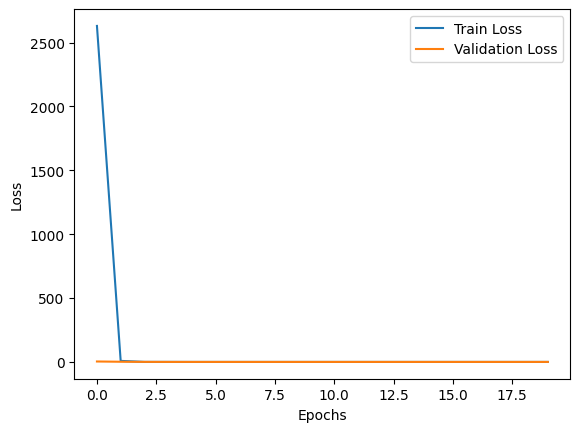

In [22]:
save_dir = r"C:\Users\91897\Desktop\CP302\ML Results\Corner\CNN"
os.makedirs(save_dir, exist_ok=True)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig(os.path.join(save_dir, 'Loss vs epochs_C2_set3_corner.png'))
plt.show()

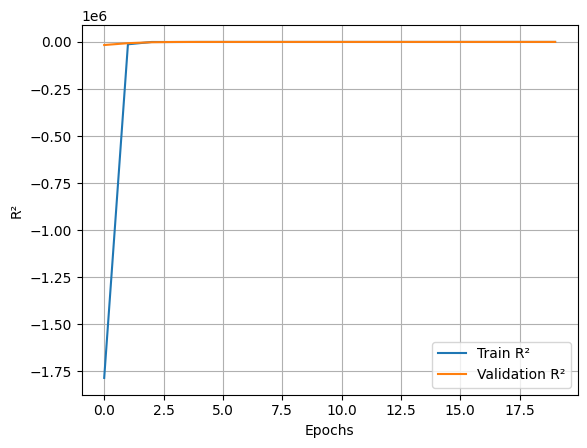

In [23]:
plt.plot(history.history['r2_keras'], label='Train R²')
plt.plot(history.history['val_r2_keras'], label='Validation R²')
plt.xlabel('Epochs')
plt.ylabel('R²')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(save_dir, 'R2_vs_Epochs_C2_set3_corner.png'))
plt.show()

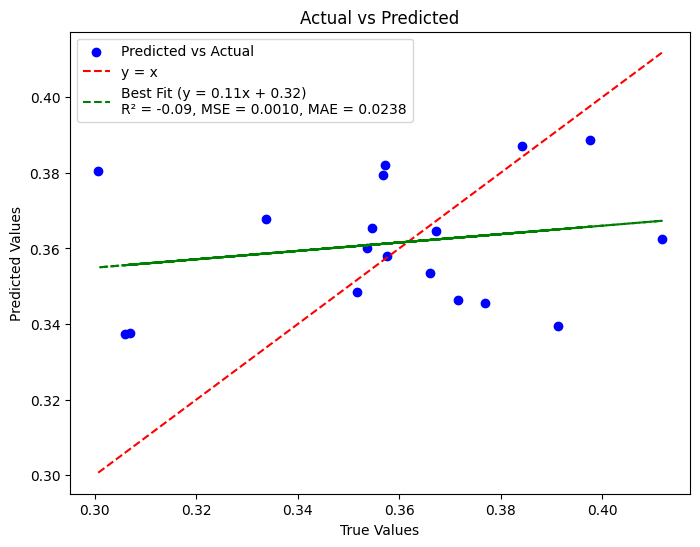

In [24]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, label='Predicted vs Actual',color = 'blue')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', label='y = x') #y=x line


r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

# Best-fit line according to the plots(Regression)
slope, intercept = np.polyfit(y_test.flatten(), y_pred.flatten(), 1)
best_fit_line = slope * y_test + intercept

plt.plot(y_test, best_fit_line, 'g--', 
         label=f'Best Fit (y = {slope:.2f}x + {intercept:.2f})\nR² = {r2:.2f}, MSE = {mse:.4f}, MAE = {mae:.4f}')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted')
plt.legend()
plt.savefig(os.path.join(save_dir, 'actual_vs_predicted_C2_set3_corner.png'))
plt.show()

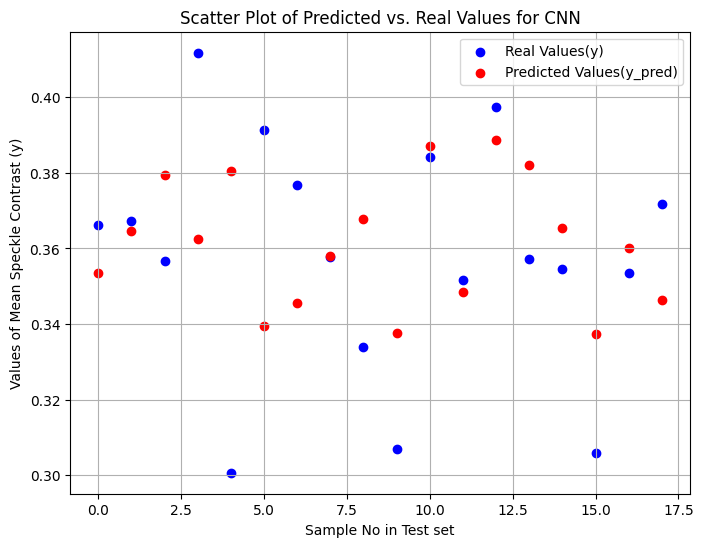

In [25]:
plt.figure(figsize=(8, 6))
plt.scatter(range(len(y_test)), y_test, color='blue', label='Real Values(y)')
plt.scatter(range(len(y_pred)), y_pred, color='red', label='Predicted Values(y_pred)')
plt.title('Scatter Plot of Predicted vs. Real Values for CNN')
plt.ylabel('Values of Mean Speckle Contrast (y)')
plt.xlabel('Sample No in Test set')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(save_dir, 'Scatter_plot_C2_set3_corner.png'))
plt.show()